In [1]:
# Basic libraries
import torch
import torch.nn as n
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from typing import List
import torch.optim as optim
from tqdm import tqdm
from omegaconf import OmegaConf
import time
# Set random seed for reproducibility
torch.manual_seed(0)

In [2]:
os.chdir("../")
# Personalized modules
from preprocess.dataloader import AntibodiesTree
from preprocess.patches_utils import PatchesUtilities

from osgen.embeddings import StyleExtractor
from osgen.utils import Utilities
from osgen.vae import VanillaVAE,VanillaEncoder, VanillaDecoder
from osgen.base import BaseModel
from osgen.nn import *
from osgen.unet import *
from osgen.loss import *
from osgen.pipeline import *

In [3]:
# Load config
cfg = OmegaConf.load("/root/BiOSGen/configs/train_config.yml")
print(cfg.verbose)

True


In [4]:
# SRC antibodies
tree_src = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/HE",
    mask_dir = "/root/BiOSGen/data/tissue_masks/HE",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/HE"
)

# DST antibodies
tree_dst = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/NKX3",
    mask_dir = "/root/BiOSGen/data/tissue_masks/NKX3",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/NKX3"
)

# Print
print("Nb antibodies: ", tree_src.get_nb_antibodies())
print("Nb antibodies: ", tree_dst.get_nb_antibodies())

Nb antibodies:  248
Nb antibodies:  248


In [5]:
idx_src = 20 # torch.randint(0, len(tree_src.antibodies), (1,)).item()
patches_src = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_src.antibodies[idx_src])),
    tissue_mask=PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[idx_src])))
)

idx_dst = 60
patches_dst = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_dst.antibodies[idx_dst])),
    tissue_mask=PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_dst.antibodies[idx_dst])))
)
print("idx_src: ", idx_src)
print("idx_dst: ", idx_dst)

idx_src:  20
idx_dst:  60


In [6]:
# Initialize your pipeline
pipeline = OSGenPipeline()

# Load the checkpoint file (a state_dict)
checkpoints = torch.load("/root/BiOSGen/checkpoints/20250609-200558/pipeline_full_100_99_epoch_512.pth")
time_stamps = "20250609-200558"


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 378MB/s]
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 88.8MB/s] 
/tmp/ipykernel_12134/773615358.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly al

FileNotFoundError: [Errno 2] No such file or directory: '/root/BiOSGen/checkpoints/20250609-200558/pipeline_full_100_99_epoch_512.pth'

In [22]:
checkpoint_keys = set(checkpoints['model_state_dict'].keys())
pipeline_keys = set(pipeline.state_dict().keys())

print("Keys only in checkpoint:", checkpoint_keys - pipeline_keys)
print("Keys only in pipeline:", pipeline_keys - checkpoint_keys)
print("Common keys:", checkpoint_keys & pipeline_keys)

# Check for shape mismatches in common keys
print("\nShape mismatches:")
for key in checkpoint_keys & pipeline_keys:
    if checkpoints['model_state_dict'][key].shape != pipeline.state_dict()[key].shape:
        print(f"{key}: checkpoint shape = {checkpoints['model_state_dict'][key].shape}, pipeline shape = {pipeline.state_dict()[key].shape}")

Keys only in checkpoint: set()
Keys only in pipeline: set()
Common keys: {'unet.middle_block.2.resblock.emb_layers.1.weight', 'style_extractor.resnet.5.2.bn3.num_batches_tracked', 'style_extractor.resnet.7.2.bn1.running_mean', 'unet.middle_block.0.resblock.out_norm.bias', 'encoder.fc_mu.weight', 'decoder.encoder.0.1.weight', 'style_extractor.resnet.6.0.bn3.running_mean', 'encoder.fc_var.weight', 'style_extractor.resnet.7.1.bn2.bias', 'unet.output_blocks.4.0.resblock.out_norm.bias', 'unet.output_blocks.7.0.resblock.emb_layers.1.bias', 'unet.output_blocks.3.0.resblock.out_conv.weight', 'decoder.fc_var.bias', 'unet.input_blocks.4.0.resblock.out_conv.bias', 'unet.output_blocks.8.0.resblock.emb_layers.1.bias', 'style_extractor.resnet.6.4.bn2.bias', 'style_extractor.resnet.7.0.downsample.1.bias', 'unet.output_blocks.4.0.post_adain.channel_reducer.weight', 'style_extractor.vgg.16.bias', 'style_extractor.resnet.6.2.bn2.bias', 'unet.input_blocks.5.0.resblock.in_norm.bias', 'style_extractor.resn

In [23]:
# Load the state_dict into the pipeline
pipeline.load_state_dict(checkpoints['model_state_dict'], strict=False)
pipeline.state_dict()

OrderedDict([('encoder.encoder.0.0.weight',
              tensor([[[[ 0.0020,  0.1011, -0.1604],
                        [-0.1455, -0.0774,  0.0457],
                        [-0.0076,  0.1442, -0.0237]],
              
                       [[ 0.0534, -0.0614, -0.0409],
                        [-0.1893, -0.1376, -0.0928],
                        [ 0.0018,  0.0603,  0.1022]],
              
                       [[-0.1273, -0.0862,  0.0676],
                        [ 0.1556, -0.0432,  0.1341],
                        [-0.0352,  0.0058,  0.1644]]],
              
              
                      [[[-0.1744, -0.1158, -0.0434],
                        [-0.0838,  0.1747, -0.1157],
                        [-0.0973, -0.1257, -0.1707]],
              
                       [[-0.1081,  0.1708,  0.0913],
                        [ 0.0845,  0.0194, -0.0885],
                        [ 0.0239, -0.1698, -0.1281]],
              
                       [[-0.0951,  0.1268,  0.1182],
            

# EVALUATION

In [24]:
pipeline.eval()

OSGenPipeline(
  (encoder): VanillaEncoder(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (fc_mu): Linear(in_features=32, out_features=64, bias=True)
    (fc_var): Linear(in_features=32, out_features=64, bias=True)
    (noise_predictor): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (decoder_input): Linear(in_features=64, out_features=8192, bias=True)
    (decoder): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=

In [26]:
# Create directory for saving data
results_dir = f"/root/BiOSGen/results/{time_stamps}"
os.makedirs(results_dir, exist_ok=True)

print("Checkpoint directory created at:", checkpoint_dir)

Checkpoint directory created at: /root/BiOSGen/results/20250609-200558


In [28]:
# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
src_stain = "HE"
dst_stain = "NKX3"

# Evaluate
for i in tqdm(range(len(tree_src.antibodies))):
    idx_src = i # torch.randint(0, len(tree_src.antibodies), (1,)).item()
    patches_src = PatchesUtilities.get_image_patches_full(
        image = np.array(Image.open(tree_src.antibodies[idx_src])),
    )

    idx_dst = torch.randint(0, len(tree_dst.antibodies), (1,)).item()
    patches_dst = PatchesUtilities.get_image_patches_full(
        image = np.array(Image.open(tree_dst.antibodies[idx_dst])),
    )

    gen = []
    with torch.no_grad():
        for i in range(len(patches_src)):
            # Assign idx_src and idx_dst to the patches
            src = patches_src[i]
            dst = patches_dst[torch.randint(0, len(patches_dst), (1,)).item()]

            # Convert to tensors
            src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
            dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

            b_size = src_tensor.size(0)
            timesteps = torch.randint(0, 1000, (b_size,), device=device)  # Random timesteps

            # forward pass
            out = pipeline(src_tensor, dst_tensor, timesteps)
            gen.append(out.to(torch.uint8)[0].permute(1,2,0).detach().cpu().numpy())

    generated = PatchesUtilities.replace_patches_in_image_full(
        original_image=np.array(Image.open(tree_src.antibodies[idx_src])),
        generated_patches=gen
    )

    # Save the generated image
    generated_image = Image.fromarray(generated)
    generated_image.save(os.path.join(results_dir, f"generated_{src_stain}_{dst_stain}_{idx_src}.png"))
    

 27%|██▋       | 68/248 [18:12<48:12, 16.07s/it]  


KeyboardInterrupt: 

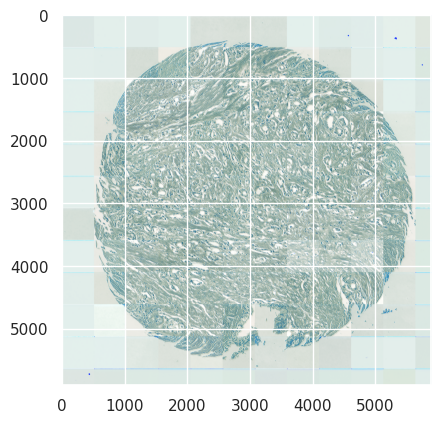

In [32]:
# Load image and display
generated_image = Image.open("/root/BiOSGen/results/20250609-200558/generated_HE_NKX3_10.png")
# show the image
plt.imshow(generated_image)